In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.lick_utils import load_licks
from utils.combine_tools import apply_qc, to_str_intlike

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO

import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import shutil 
from aind_ephys_utils import align
%matplotlib inline

In [2]:
dfs = [pd.read_csv('/root/capsule/code/data_management/session_assets.csv'),
        pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')]
df = pd.concat(dfs)
session_list = df['session_id'].values.tolist()
ani_list = [str(session).split('_')[1] for session in session_list if str(session).startswith('behavior')]
session_list = [session for session in session_list if str(session).startswith('behavior')]
ani_session_df = pd.DataFrame({'animal': ani_list, 'session_id': session_list})

In [39]:
def analyze_animal_licks(animal_id, tb = -5, tf = 5, plot=False):
    dfs = [pd.read_csv('/root/capsule/code/data_management/session_assets.csv'),
            pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')]
    df = pd.concat(dfs)
    session_list = df['session_id'].values.tolist()
    ani_list = [str(session).split('_')[1] for session in session_list if str(session).startswith('behavior')]
    session_list = [session for session in session_list if str(session).startswith('behavior')]
    ani_session_df = pd.DataFrame({'animal': ani_list, 'session_id': session_list})

    aligned_licks = []
    in_out_mask = []
    lick_len = []
    rewarded_licks = []
    session_tbl_combined = []
    sessions = ani_session_df[ani_session_df['animal'] == animal_id]['session_id'].values.tolist()
    if len(sessions) == 0:
        return
    for session in sessions:
        session_tbl = get_session_tbl(session)
        if session_tbl is None:
            continue
        # Concate licks
        licks = load_licks(session)
        aligned_licks_sess = []
        in_out_mask_sess = []
        len_sess = []
        rewarded_licks_sess = []
        all_licks = licks['lick_trains_all']['train_starts']
        in_trial_session = licks['lick_trains_all']['in_trial']
        lick_len_session = licks['lick_trains_all']['train_ends'] - licks['lick_trains_all']['train_starts']
        lick_sides = licks['lick_trains_all']['side']
        for idx, row in session_tbl.iterrows():
            choice_times = row[ 'goCue_start_time']
            mask = (all_licks >= choice_times + tb) & (all_licks <= choice_times + tf)
            if idx < (len(session_tbl) - 1):
                mask &= (all_licks < session_tbl.iloc[idx+1]['goCue_start_time'] + tb)
            if idx > 0:
                mask &= (all_licks > session_tbl.iloc[idx-1]['goCue_start_time'] + tf)
            aligned_licks_trial = list(all_licks[mask] - choice_times)
            in_out_mask_trial = list(in_trial_session[mask])
            len_trial = list(lick_len_session[mask])
            aligned_licks_sess.extend(aligned_licks_trial)
            in_out_mask_sess.extend(in_out_mask_trial)
            len_sess.extend(list(lick_len_session[mask]))

            if len(aligned_licks_trial) == 0:
                continue
            rewarded_mask_trial = np.array([False]*len(aligned_licks_trial))
            if row['rewarded_historyR'] or row['rewarded_historyL']:
                rewarded_mask_trial[np.array(in_out_mask_trial)] = True
            rewarded_licks_sess.extend(list(rewarded_mask_trial))
                
        aligned_licks.append(aligned_licks_sess)
        in_out_mask.append(in_out_mask_sess)
        lick_len.append(len_sess)
        rewarded_licks.append(rewarded_licks_sess)
        # concat beh
        # for for each session, for each trial, compute: whether there's a lick train within [2.5 to 8] after go cue but before next go cue; how long has current trial been from last switch, how long until next switch
        choices_latent = session_tbl['animal_response'].values
        no_response_ind = np.where(choices_latent == 2)[0]
        no_response_ind = no_response_ind[no_response_ind > 0]
        choices_latent[no_response_ind] = choices_latent[no_response_ind - 1]
        switch_stay = choices_latent[1:] != choices_latent[:-1]
        switch_stay_pre = np.insert(switch_stay, 0, False)
        switch_stay_post = np.append(switch_stay, np.nan)
        session_tbl['switch_stay_pre'] = switch_stay_pre
        session_tbl['switch_stay_post'] = switch_stay_post
        # for each trial, compute how long since last switch
        last_switch = np.zeros(len(session_tbl))
        for i in range(1, len(session_tbl)):
            # after a switch
            if i >= np.where(switch_stay)[0][0]:
                if session_tbl.iloc[i-1]['switch_stay_post']:
                    last_switch[i] = 0
                else:
                    last_switch[i] = last_switch[i-1] + 1
            else:
                last_switch[i] = i
        session_tbl['trials_since_last_switch'] = last_switch
        # for each trial, compute how long until next switch
        next_switch = np.zeros(len(session_tbl))
        for i in range(len(session_tbl)-2, -1, -1):
            # before a switch
            if i <= np.where(switch_stay)[0][-1]:
                if session_tbl.iloc[i]['switch_stay_post']:
                    next_switch[i] = 0
                else:
                    next_switch[i] = next_switch[i+1] + 1
            else:
                next_switch[i] = np.nan
        session_tbl['trials_until_next_switch'] = next_switch
        
        # for each trial compute if there's a lick train within [2 to 8] after go cue but before next go cue
        lick_in_trial_post = np.zeros(len(session_tbl), dtype=bool)
        lick_in_trial_side = np.array([np.nan]*len(session_tbl))
        for idx, row in session_tbl.iterrows():
            align_time = row['goCue_start_time']
            mask = (all_licks >= align_time + 2) & (all_licks <= align_time + 8)
            if idx < (len(session_tbl) - 1):
                next_trial_start = session_tbl.iloc[idx+1]['goCue_start_time']
            else:
                next_trial_start = np.inf
            
            if np.sum(mask) > 0:
                lick_in_trial_post[idx] = True
            if np.all(all_licks[mask]) > next_trial_start:
                lick_in_trial_post[idx] = np.nan
            
            if lick_in_trial_post[idx]:
                lick_side_curr = 2*(lick_sides[mask] - 0.5)
                lick_in_trial_side[idx] = np.mean(lick_side_curr)
        session_tbl['lick_in_trial_post'] = lick_in_trial_post
        session_tbl['lick_in_trial_side_post'] = lick_in_trial_side

        # lick in following ITI
        lick_in_iti = np.zeros(len(session_tbl), dtype=bool)
        lick_in_iti_side = np.array([np.nan]*len(session_tbl))
        lick_in_iti_time = np.array([np.nan]*len(session_tbl))
        for idx, row in session_tbl.iterrows():
            align_time = row['goCue_start_time']
            if idx < (len(session_tbl) - 1):
                next_trial_start = session_tbl.iloc[idx+1]['goCue_start_time']
            else:
                next_trial_start = np.inf
            mask = (all_licks > align_time + 2) & (all_licks < next_trial_start)
            if np.sum(mask) > 0:
                lick_in_iti[idx] = True
            
            if lick_in_iti[idx]:
                lick_side_curr = 2*(lick_sides[mask] - 0.5)
                lick_in_iti_side[idx] = lick_side_curr[0]
                lick_in_iti_time[idx] = all_licks[mask][0] - align_time
        
        session_tbl['lick_in_iti'] = lick_in_iti
        session_tbl['lick_in_iti_side'] = lick_in_iti_side
        session_tbl['lick_in_iti_time'] = lick_in_iti_time

        # licks before choice
        lick_in_trial_pre = np.zeros(len(session_tbl), dtype=bool)
        lick_in_trial_side_pre = np.array([np.nan]*len(session_tbl))
        for idx, row in session_tbl.iterrows():
            align_time = row['goCue_start_time']
            mask = (all_licks >= align_time - 5) & (all_licks <= align_time)
            if idx > 0:
                prev_trial_end = session_tbl.iloc[idx-1]['goCue_start_time']
            else:
                prev_trial_end = -np.inf
            
            if np.sum(mask) > 0:
                lick_in_trial_pre[idx] = True
            if np.all(all_licks[mask]) < prev_trial_end:
                lick_in_trial_pre[idx] = np.nan
            
            if lick_in_trial_pre[idx]:
                lick_side_curr = 2*(lick_sides[mask] - 0.5)
                lick_in_trial_side_pre[idx] = np.mean(lick_side_curr)
        session_tbl['lick_in_trial_pre'] = lick_in_trial_pre
        session_tbl['lick_in_trial_side_pre'] = lick_in_trial_side_pre

        session_tbl['outcome'] = session_tbl['rewarded_historyR'] | session_tbl['rewarded_historyL']
        session_tbl['outcome_pre'] = np.insert(session_tbl['outcome'].values[:-1], 0, False)
        session_tbl['choice'] = np.nan
        session_tbl.loc[session_tbl['animal_response'] == 1, 'choice'] = 1
        session_tbl.loc[session_tbl['animal_response'] == 0, 'choice'] = 0
        session_tbl['choice_pre'] = np.insert(session_tbl['choice'].values[:-1], 0, np.nan)
        session_tbl['choice_next'] = np.append(session_tbl['choice'].values[1:], np.nan)
        session_tbl['iti_length' ] = np.append(np.diff(session_tbl['goCue_start_time'].values), np.nan)

        session_tbl_combined.append(session_tbl)
    if len(aligned_licks) == 0:
        return
    
    # Compute session-wise statistics
    len_session_mean = [np.mean(np.array(lick_len_sess)) if len(lick_len_sess) > 0 else np.nan for lick_len_sess in lick_len]
    len_in_rwd_session_mean = [np.mean(np.array(lick_len_sess)[np.array(in_out_mask_sess) & np.array(rewarded_licks_session)]) 
                                if np.sum(np.array(in_out_mask_sess) & np.array(rewarded_licks_session)) > 0 else 0 
                                for lick_len_sess, in_out_mask_sess, rewarded_licks_session in zip(lick_len, in_out_mask, rewarded_licks)]
    len_in_no_rwd_session_mean = [np.mean(np.array(lick_len_sess)[np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session)])
                                if np.sum(np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session)) > 0 else 0
                                for lick_len_sess, in_out_mask_sess, rewarded_licks_session in zip(lick_len, in_out_mask, rewarded_licks)]
    len_out_session_mean = [np.mean(np.array(lick_len_sess)[~np.array(in_out_mask_sess)]) if np.sum(~np.array(in_out_mask_sess)) > 0 else 0 for lick_len_sess, in_out_mask_sess in zip(lick_len, in_out_mask)]
    
    
    count_session = [len(lick_len_sess) for lick_len_sess in lick_len]
    count_in_rwd_session = [np.sum(np.array(in_out_mask_sess) & np.array(rewarded_licks_session)) 
                            for in_out_mask_sess, rewarded_licks_session in zip(in_out_mask, rewarded_licks)]
    count_in_nrwd_session = [np.sum(np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session))
                            for in_out_mask_sess, rewarded_licks_session in zip(in_out_mask, rewarded_licks)]
    count_out_session = [np.sum(~np.array(in_out_mask_sess)) for in_out_mask_sess in in_out_mask]

    quantiles = [0.25, 0.5, 0.75]
    quantiles_session = [np.quantile(np.array(lick_len_sess), quantiles) if len(lick_len_sess) > 0 else [np.nan]*len(quantiles) for lick_len_sess in lick_len]
    quantiles_in_rwd_session = [np.quantile(np.array(lick_len_sess)[np.array(in_out_mask_sess) & np.array(rewarded_licks_session)], quantiles) 
                                if np.sum(np.array(in_out_mask_sess) & np.array(rewarded_licks_session)) > 0 else [np.nan]*len(quantiles) 
                                for lick_len_sess, in_out_mask_sess, rewarded_licks_session in zip(lick_len, in_out_mask, rewarded_licks)]
    qualtiles_in_nrwd_session = [np.quantile(np.array(lick_len_sess)[np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session)], quantiles)
                                if np.sum(np.array(in_out_mask_sess) & ~np.array(rewarded_licks_session)) > 0 else [np.nan]*len(quantiles)
                                for lick_len_sess, in_out_mask_sess, rewarded_licks_session in zip(lick_len, in_out_mask, rewarded_licks)]
    quantiles_out_session = [np.quantile(np.array(lick_len_sess)[~np.array(in_out_mask_sess)], quantiles) if np.sum(~np.array(in_out_mask_sess)) > 0 else [np.nan]*len(quantiles) for lick_len_sess, in_out_mask_sess in zip(lick_len, in_out_mask)]

    ratio_session = [np.mean(in_out_mask_sess) if len(lick_len_sess) > 0 else np.nan for lick_len_sess, in_out_mask_sess in zip(lick_len, in_out_mask)]

    # Combine all session-wise list into a big list
    lick_len = [item for sublist in lick_len for item in sublist]
    aligned_licks = [item for sublist in aligned_licks for item in sublist]
    in_out_mask = [item for sublist in in_out_mask for item in sublist]
    rewarded_licks = [item for sublist in rewarded_licks for item in sublist]

    len_mean_combined = np.mean(np.array(lick_len))
    len_mean_out_combined = np.mean(np.array(lick_len)[~np.array(in_out_mask)])
    len_mean_in_rwd_combined = np.mean(np.array(lick_len)[np.array(in_out_mask) & np.array(rewarded_licks)])
    len_mean_in_nrwd_combined = np.mean(np.array(lick_len)[np.array(in_out_mask) & ~np.array(rewarded_licks)])
    quantiles_combined = np.quantile(np.array(lick_len), quantiles)
    quantiles_out_combined = np.quantile(np.array(lick_len)[~np.array(in_out_mask)], quantiles)
    quantiles_in_rwd_combined = np.quantile(np.array(lick_len)[np.array(in_out_mask) & np.array(rewarded_licks)], quantiles)
    quantiles_in_nrwd_combined = np.quantile(np.array(lick_len)[np.array(in_out_mask) & ~np.array(rewarded_licks)], quantiles)


    
    results = {'session_ids': sessions,
            'all_licks': {'len_mean': len_session_mean,
                        'count': count_session,
                        'quantiles': quantiles_session},
            'in_trial_rwd_licks': {'len_mean': len_in_rwd_session_mean,
                'count': count_in_rwd_session,
                'quantiles': quantiles_in_rwd_session},
            'in_trial_no_rwd_licks': {'len_mean': len_in_no_rwd_session_mean,
                'count': count_in_nrwd_session,
                'quantiles': qualtiles_in_nrwd_session},
            'out_of_trial_licks': {'len_mean': len_out_session_mean,
                'count': count_out_session,
                'quantiles': quantiles_out_session},
            'in_out_ratio': ratio_session,
            'combined': {'all': {'len_mean': len_mean_combined,
                                'quantiles': quantiles_combined},
                        'in_trial_rwd': {'len_mean': len_mean_in_rwd_combined,
                                        'quantiles': quantiles_in_rwd_combined},
                        'in_trial_no_rwd': {'len_mean': len_mean_in_nrwd_combined,
                                            'quantiles': quantiles_in_nrwd_combined},
                        'out_of_trial': {'len_mean': len_mean_out_combined,
                                        'quantiles': quantiles_out_combined}
                        }
            }
        
    # save combined results to pickle
    save_file = f'/root/capsule/scratch/{animal_id}/ani_combinded/lick_train_stats.pkl'
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)

    # model
    session_tbl_combined = pd.concat(session_tbl_combined)
    # convert all boolean columns to numeric
    bool_cols = session_tbl_combined.select_dtypes(include=['bool']).columns
    session_tbl_combined[bool_cols] = session_tbl_combined[bool_cols].astype(int)

    # zscore if not only between -1 and 1
    for col in ['trials_since_last_switch', 'trials_until_next_switch']:
        session_tbl_combined[col] = session_tbl_combined[col].values/10
    
    model_post = 'lick_in_trial_post ~ trials_since_last_switch + trials_until_next_switch + outcome'
    model_pre = 'lick_in_trial_pre ~ trials_since_last_switch + trials_until_next_switch + outcome_pre'
    model_iti = 'lick_in_iti ~ trials_since_last_switch + switch_stay_post + outcome + iti_length'
    model_side_post = 'lick_in_trial_side_post ~ choice'
    model_side_pre = 'lick_in_trial_side_pre ~ choice_pre'
    model_side_iti = 'lick_in_iti_side ~ choice*lick_in_iti_time + choice'
    
    try:
        lm_post = sm.Logit.from_formula(model_post, data=session_tbl_combined).fit()
    except:
        lm_post = None
        print(f'{session} Post model failed to fit')
    try:
        lm_pre = sm.Logit.from_formula(model_pre, data=session_tbl_combined).fit()
    except:
        lm_pre = None
        print(f'{session} Pre model failed to fit')
    try:
        lm_iti = sm.Logit.from_formula(model_iti, data=session_tbl_combined).fit()
    except:
        lm_iti = None
        print(f'{session} ITI model failed to fit')
    try:
        lm_side_post = sm.OLS.from_formula(model_side_post, data=session_tbl_combined).fit()
    except:
        lm_side_post = None
        print(f'{session} Side post model side failed to fit')
    try:
        lm_side_pre = sm.OLS.from_formula(model_side_pre, data=session_tbl_combined).fit()
    except:
        lm_side_pre = None
        print(f'{session} Side pre model side failed to fit')
    try:
        lm_side_iti = sm.Logit.from_formula(model_side_iti, data=session_tbl_combined).fit()
    except:
        lm_side_iti = None
        print(f'{session} Side iti model side failed to fit')

    # save model results to pickle
    model_results = {'lm_post': lm_post,
                    'lm_pre': lm_pre,
                    'lm_side_post': lm_side_post,
                    'lm_side_pre': lm_side_pre,
                    'lm_iti': lm_iti,
                    'lm_side_iti': lm_side_iti}
    save_file = f'/root/capsule/scratch/{animal_id}/ani_combinded/lick_in_trial_model.pkl'
    with open(save_file, 'wb') as f:
        pickle.dump(model_results, f)

    if plot:
        # train_lens
        fig = plt.figure(figsize=(8,4))
        gs = gridspec.GridSpec(1,2)
        # lick time
        ax1 = fig.add_subplot(gs[0, 0])
        edges = np.linspace(tb, tf, 50)
        ax1.hist(np.array(aligned_licks)[np.array(in_out_mask)], bins=edges, density=True, color='k', label='in-trial');
        ax1.hist(np.array(aligned_licks)[~np.array(in_out_mask)], bins=edges, density=True, alpha=0.5, color='gray', label='out-of-trial');
        ax1.set_title(f'Lick times aligned to choice, out = {np.sum(~np.array(in_out_mask))}, in = {np.sum(np.array(in_out_mask))}')
        ax1.set_xlabel('Time from choice (s)')
        ax1.set_ylabel('Density')
        ax1.legend()

        ax = fig.add_subplot(gs[0, 1])
        edges = np.linspace(np.min(lick_len), np.max(lick_len), 30)
        ax.hist(np.array(lick_len)[np.array(in_out_mask) & np.array(rewarded_licks)], bins=edges, color='r', label='in-trial_R', density=True);
        ax.hist(np.array(lick_len)[np.array(in_out_mask) & ~np.array(rewarded_licks)], bins=edges, color='k', label='in-trial_N', density=True);
        ax.hist(np.array(lick_len)[~np.array(in_out_mask)], bins=edges, alpha=0.5, color='gray', label='out-of-trial', density=True);
        ax.set_title('Lick train lengths')
        ax.set_xlabel('Lick train length (s)')
        ax.set_ylabel('Density')
        ax.legend()

        plt.suptitle(f'Animal {animal_id} lick statistics across {len(sessions)} sessions')
        ani_dir = f'/root/capsule/scratch/{animal_id}/ani_combinded'
        if not os.path.exists(ani_dir):
            os.makedirs(ani_dir)
        plt.tight_layout()
        fig.savefig(fname=os.path.join(ani_dir, 'lick_trains.pdf'), dpi=300)

        # plot model results as coefficient bar plots
        fig = plt.figure(figsize=(8,8))
        gs = gridspec.GridSpec(3, 2)
        # pre model
        if lm_pre is not None:
            ax1 = fig.add_subplot(gs[0, 0])

            z_pre   = lm_pre.tvalues[1:]
            sig_pre = lm_pre.pvalues[1:] < 0.05

            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_pre.values]

            ax1.bar(
                z_pre.index,
                z_pre.values,
                color=colors,
                alpha=0.7,
            )

            ax1.set_title('Spont licks (pre-choice)')
            ax1.set_ylabel('z value')
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        if lm_side_pre is not None:
            ax2 = fig.add_subplot(gs[0, 1])
            z_side_pre   = lm_side_pre.tvalues[1:]
            sig_side_pre = lm_side_pre.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_side_pre.values]
            ax2.bar(
                z_side_pre.index,
                z_side_pre.values,
                color=colors,
                alpha=0.7,
            )
            ax2.set_title('Spont licks side (pre-choice)')
            ax2.set_ylabel('z value')
            ax2.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        if lm_post is not None:
            # post model
            ax3 = fig.add_subplot(gs[1, 0])
            z_post   = lm_post.tvalues[1:]
            sig_post = lm_post.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_post.values]
            ax3.bar(
                z_post.index,
                z_post.values,
                color=colors,
                alpha=0.7,
            )
            ax3.set_title('Spont licks (post-choice)')
            ax3.set_ylabel('z value')
            ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        if lm_side_post is not None:
            ax4 = fig.add_subplot(gs[1, 1])
            z_side_post   = lm_side_post.tvalues[1:]
            sig_side_post = lm_side_post.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_side_post.values]
            ax4.bar(
                z_side_post.index,
                z_side_post.values,
                color=colors,
                alpha=0.7,
            )
            ax4.set_title('Spont licks side (post-choice)')
            ax4.set_ylabel('z value')
            ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
        if lm_iti is not None:
            ax5 = fig.add_subplot(gs[2, 0])
            z_iti   = lm_iti.tvalues[1:]
            sig_iti = lm_iti.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_iti.values]
            ax5.bar(
                z_iti.index,
                z_iti.values,
                color=colors,
                alpha=0.7,
            )
            ax5.set_title('Spont licks (ITI)')
            ax5.set_ylabel('z value')
            ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
        if lm_side_iti is not None:
            ax6 = fig.add_subplot(gs[2, 1])
            z_side_iti   = lm_side_iti.tvalues[1:]
            sig_side_iti = lm_side_iti.pvalues[1:] < 0.05
            # colors per bar
            colors = ['r' if sig else 'gray' for sig in sig_side_iti.values]
            ax6.bar(
                z_side_iti.index,
                z_side_iti.values,
                color=colors,
                alpha=0.7,
            )
            ax6.set_title('Spont licks side (ITI)')
            ax6.set_ylabel('z value')
            ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
            

        plt.suptitle(f'Animal {animal_id} lick in-trial model coefficients across {len(sessions)} sessions')
        plt.tight_layout()
        fig.savefig(fname=os.path.join(ani_dir, 'lick_in_trial_model_coefficients.pdf'), dpi=300)


In [40]:
from joblib import Parallel, delayed
animal_ids = ani_session_df['animal'].unique().tolist()
Parallel(n_jobs=10)(delayed(analyze_animal_licks)(animal_id, plot=False) for animal_id in animal_ids)

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.550985
         Iterations 5
         Current function value: 0.017344
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.452554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409516
         Iterations 7
         Current function value: 0.010921
         Iterations: 35
behavior_722832_2024-09-13_11-55-58 Pre model failed to fit
behavior_739977_2024-10-24_12-58-26 Side iti model side failed to fit
Optimization terminated successfully.
         Current function value: 0.211513
         Iterations 7
behavior_722832_2024-09-13_11-55-58 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.590870
         Iterations 5
         Current function value: 0.006788
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.068954
         Iterations 11
behavior_739970_2024-10-16_12-15-24 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.599862
         Iterations 5
         Current function value: 0.010467
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.287601
         Iterations 7
behavior_724172_2024-10-03_11-02-53 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.513854
         Iterations 6
         Current function value: 0.015910
         Iterations: 35
behavior_714116_2024-08-29_11-46-43 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.363951
         Iterations 7
behavior_714116_2024-08-29_11-46-43 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.612553
         Iterations 5
         Current function value: 0.012795
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.258342
         Iterations 7
behavior_717263_2024-07-25_10-02-21 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.648244
         Iterations 5
         Current function value: 0.009195
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.347155
         Iterations 7
behavior_717259_2024-06-28_11-17-19 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.645293
         Iterations 5
         Current function value: 0.009483
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.414683
         Iterations 7
behavior_716325_2024-06-01_09-25-37 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.667940
         Iterations 4
         Current function value: 0.011620
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.338778
         Iterations 7
behavior_751769_2025-01-18_10-15-25 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _method

Optimization terminated successfully.
         Current function value: 0.662363
         Iterations 4
         Current function value: 0.009533
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.224494
         Iterations 7
behavior_717121_2024-06-16_11-45-02 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680776
         Iterations 4
         Current function value: 0.011082
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.179287
         Iterations 8
behavior_758017_2025-02-07_14-11-08 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.638893
         Iterations 5
         Current function value: 0.015887
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.337433
         Iterations 7
behavior_751181_2025-02-27_11-24-47 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.642616
         Iterations 5
         Current function value: 0.007765
         Iterations: 35
behavior_751004_2024-12-23_14-20-03 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.371644
         Iterations 7
behavior_751004_2024-12-23_14-20-03 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.627262
         Iterations 5
         Current function value: 0.009467
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.200671
         Iterations 8
behavior_758018_2025-03-21_11-00-34 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.616661
         Iterations 5
         Current function value: 0.008624
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.233132
         Iterations 8
behavior_751766_2025-02-15_12-08-11 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.626303
         Iterations 5
         Current function value: 0.010279
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.128699
         Iterations 9
behavior_763590_2025-05-02_11-07-09 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.636317
         Iterations 5
         Current function value: 0.010188
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.256496
         Iterations 8
behavior_752014_2025-03-28_11-04-59 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.618852
         Iterations 5
         Current function value: 0.011905
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.475293
         Iterations 6
behavior_761038_2025-04-18_12-37-39 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.646721
         Iterations 5
         Current function value: 0.012095
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.175440
         Iterations 8
behavior_782394_2025-04-25_11-13-21 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: 0.665893
         Iterations 4
         Current function value: inf
         Iterations: 35
behavior_754897_2025-03-15_11-32-18 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.107508
         Iterations 9
behavior_754897_2025-03-15_11-32-18 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671701
         Iterations 4
         Current function value: 0.010469
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.104795
         Iterations 8
behavior_785956_2025-05-23_13-45-21 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.604921
         Iterations 5
         Current function value: 0.014602
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.431050
         Iterations 7
behavior_784806_2025-06-20_13-39-16 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.649480
         Iterations 5
         Current function value: inf
         Iterations: 35
behavior_781166_2025-05-16_14-16-34 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.080232
         Iterations 9
behavior_781166_2025-05-16_14-16-34 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.636348
         Iterations 5
         Current function value: inf
         Iterations: 35
behavior_784803_2025-07-03_13-55-13 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.316532
         Iterations 7
behavior_784803_2025-07-03_13-55-13 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.
No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.615068
         Iterations 5
         Current function value: 0.008845
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.219299
         Iterations 8
behavior_791691_2025-06-27_13-54-30 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.
No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.
No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.662757
         Iterations 4
         Current function value: inf
         Iterations: 35
behavior_ZS060_2021-04-29_15-15-00 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.145072
         Iterations 8
behavior_ZS060_2021-04-29_15-15-00 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Optimization terminated successfully.
         Current function value: 0.663933
         Iterations 4
         Current function value: 0.013630
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.327709
         Iterations 7
behavior_ZS059_2021-04-29_14-02-45 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _method

Optimization terminated successfully.
         Current function value: 0.662390
         Iterations 4
         Current function value: 0.012345
         Iterations: 35
behavior_ZS061_2021-05-01_18-28-14 Pre model failed to fit
Optimization terminated successfully.
         Current function value: 0.194755
         Iterations 7
behavior_ZS061_2021-05-01_18-28-14 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.663455
         Iterations 4
         Current function value: 0.012875
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.181315
         Iterations 8
behavior_ZS062_2021-05-11_20-10-59 Side iti model side failed to fit


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [33]:
# load data from all animals and plot summary statistics
animal_ids = ani_session_df['animal'].unique().tolist()
all_results = []
all_results_model = []
for animal_id in animal_ids:
    save_file = f'/root/capsule/scratch/{animal_id}/ani_combinded/lick_train_stats.pkl'
    if os.path.exists(save_file):
        with open(save_file, 'rb') as f:
            results = pickle.load(f)
        results['animal_id'] = animal_id
        all_results.append(results)
    else:
        print(f'No lick stats for animal {animal_id}')
    save_file = f'/root/capsule/scratch/{animal_id}/ani_combinded/lick_in_trial_model.pkl'
    if os.path.exists(save_file):
        with open(save_file, 'rb') as f:
            model_results = pickle.load(f)
        model_results['animal_id'] = animal_id
        all_results_model.append(model_results)
    else:
        print(f'No lick model for animal {animal_id}')

No lick stats for animal 744779
No lick model for animal 744779


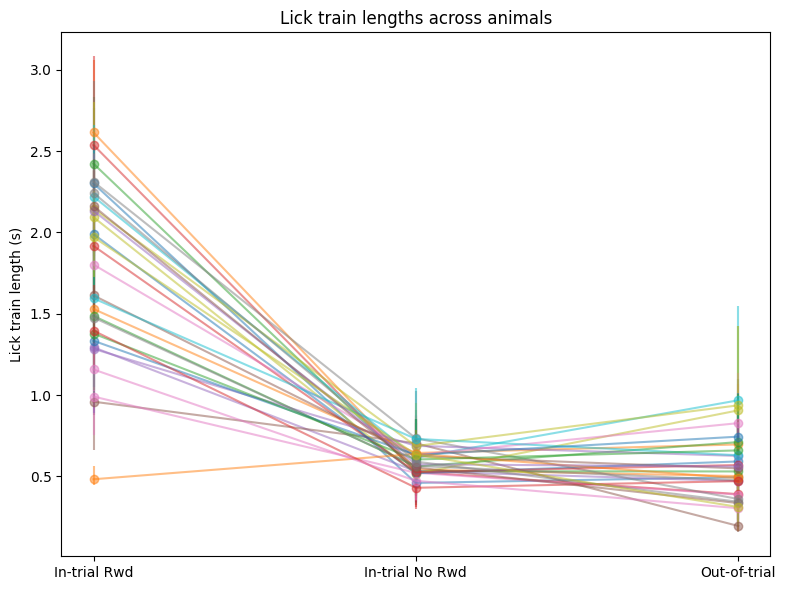

In [41]:
len_out_mean_ani_combined = [np.mean(result['combined']['out_of_trial']['len_mean']) for result in all_results]
len_in_rwd_mean_ani_combined = [np.mean(result['combined']['in_trial_rwd']['len_mean']) for result in all_results]
len_in_nrwd_mean_ani_combined = [np.mean(result['combined']['in_trial_no_rwd']['len_mean']) for result in all_results]

quantiles_out_ani_combined = [result['combined']['out_of_trial']['quantiles'] for result in all_results]
quantiles_in_rwd_ani_combined = [result['combined']['in_trial_rwd']['quantiles'] for result in all_results]
quantiles_in_nrwd_ani_combined = [result['combined']['in_trial_no_rwd']['quantiles'] for result in all_results]

# for all animal error bar plot for rwd - nrwd - out, mean, 25, 50, 75 quantiles, each animal has one line
fig = plt.figure(figsize=(8,6))
x = range(3)
for ani_ind in range(len(len_in_nrwd_mean_ani_combined)):
    means = [len_in_rwd_mean_ani_combined[ani_ind], len_in_nrwd_mean_ani_combined[ani_ind], len_out_mean_ani_combined[ani_ind]]
    q25 = [quantiles_in_rwd_ani_combined[ani_ind][0], quantiles_in_nrwd_ani_combined[ani_ind][0], quantiles_out_ani_combined[ani_ind][0]]
    q50 = [quantiles_in_rwd_ani_combined[ani_ind][1], quantiles_in_nrwd_ani_combined[ani_ind][1], quantiles_out_ani_combined[ani_ind][1]]
    q75 = [quantiles_in_rwd_ani_combined[ani_ind][2], quantiles_in_nrwd_ani_combined[ani_ind][2], quantiles_out_ani_combined[ani_ind][2]]
    plt.errorbar(x, q50, yerr=[np.array(q50) - np.array(q25), np.array(q75) - np.array(q50)], fmt='-o', alpha=0.5)
plt.xticks(x, ['In-trial Rwd', 'In-trial No Rwd', 'Out-of-trial'])
plt.ylabel('Lick train length (s)')
plt.title('Lick train lengths across animals')
plt.tight_layout()
# plt.savefig('/root/capsule/scratch/combined_lick_train_lengths_across_animals.pdf', dpi=300)

In [42]:
# load all model results into a list
fit_values = {'post': [], 'pre': [], 'iti': [], 'side_post': [], 'side_pre': [], 'side_iti': []}
for result in all_results_model:
    animal_id = result['animal_id']
    for key in fit_values.keys():
        lm_key = 'lm_' + key
        lm = result[lm_key]
        if lm is not None:
            if key.startswith('side'):
                z_vals = lm.tvalues
                p_vals = lm.pvalues
            else:
                z_vals = lm.tvalues[1:]
                p_vals = lm.pvalues[1:]
            curr_df = pd.DataFrame({'animal_id': animal_id, 'regressor': z_vals.index, 'z_value': z_vals.values, 'model': key, 'p_value': p_vals.values})
            fit_values[key].append(curr_df)
# combine each field into one dataframe
for key in fit_values.keys():
    fit_values[key] = pd.concat(fit_values[key])



/tmp/ipykernel_1302813/4291692537.py:22: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


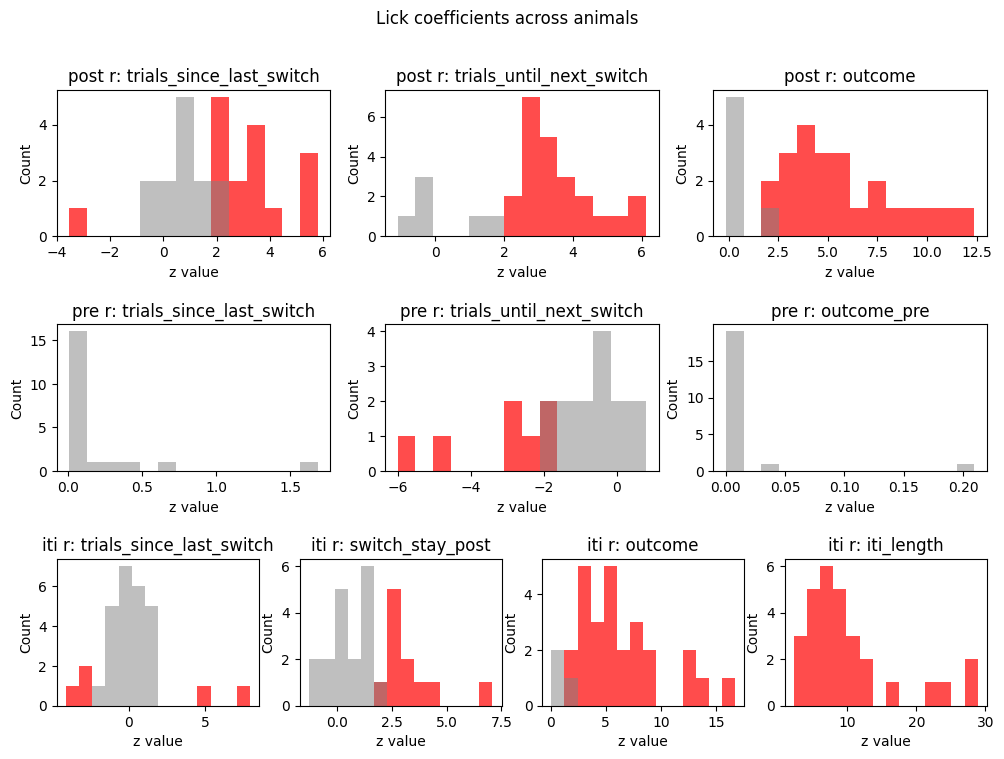

In [44]:
# plot model z values across animals as histograms
# each row is a model (post, pre, iti), each column is a regressor
fig = plt.figure(figsize=(12,8))
model_keys = ['post', 'pre', 'iti']
for row_ind, model_key in enumerate(model_keys):
    model_df = fit_values[model_key]
    regressors = model_df['regressor'].unique().tolist()
    for col_ind, regressor in enumerate(regressors):
        ax = fig.add_subplot(len(model_keys), len(regressors), row_ind*len(regressors) + col_ind + 1)
        reg_df = model_df[model_df['regressor'] == regressor]
        # significant in red, non-significant in gray
        sig_mask = reg_df['p_value'] < 0.05
        bin_edges = np.linspace(np.min(reg_df['z_value']), np.max(reg_df['z_value']), 15)
        ax.hist(reg_df[sig_mask]['z_value'], bins=bin_edges, color='r', alpha=0.7, label='p < 0.05')
        ax.hist(reg_df[~sig_mask]['z_value'], bins=bin_edges, color='gray', alpha=0.5, label='p >= 0.05')

        ax.set_title(f'{model_key} r: {regressor}')
        ax.set_xlabel('z value')
        ax.set_ylabel('Count')
plt.suptitle('Lick coefficients across animals')
fig.subplots_adjust(hspace=0.6)
plt.tight_layout()

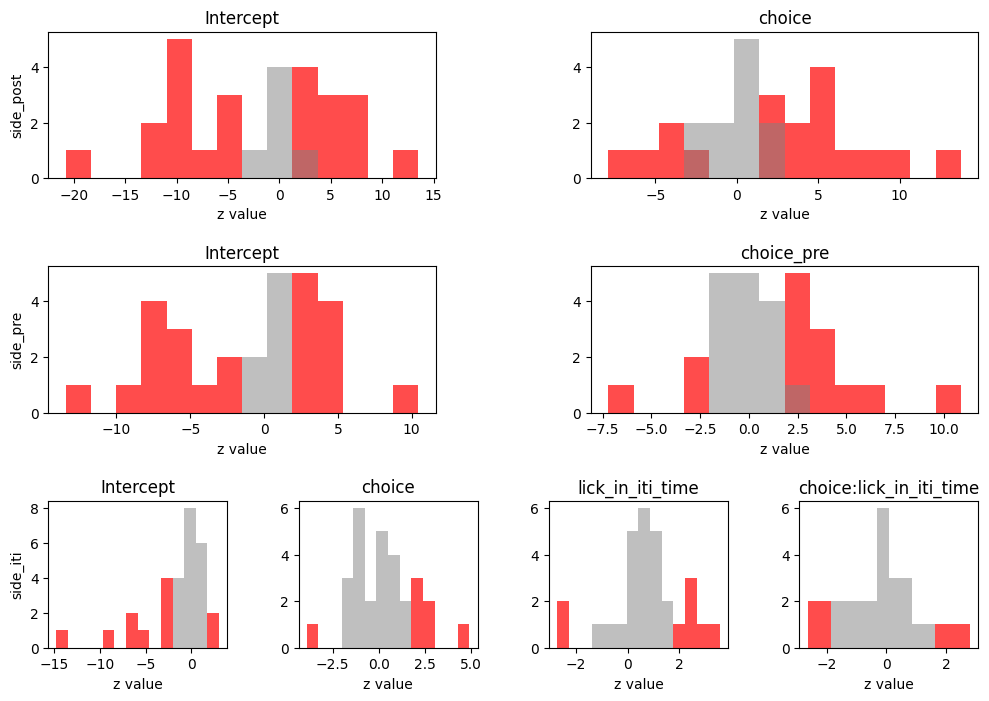

In [45]:
model_keys = ['side_post', 'side_pre', 'side_iti']
fig = plt.figure(figsize=(12,8))
for row_ind, model_key in enumerate(model_keys):
    model_df = fit_values[model_key]
    regressors = model_df['regressor'].unique().tolist()
    for col_ind, regressor in enumerate(regressors):
        ax = fig.add_subplot(len(model_keys), len(regressors), row_ind*len(regressors) + col_ind + 1)
        reg_df = model_df[model_df['regressor'] == regressor]
        # significant in red, non-significant in gray
        sig_mask = reg_df['p_value'] < 0.05
        bin_edges = np.linspace(np.min(reg_df['z_value']), np.max(reg_df['z_value']), 15)
        ax.hist(reg_df[sig_mask]['z_value'], bins=bin_edges, color='r', alpha=0.7, label='p < 0.05')
        ax.hist(reg_df[~sig_mask]['z_value'], bins=bin_edges, color='gray', alpha=0.5, label='p >= 0.05')

        ax.set_title(f'{regressor}')
        ax.set_xlabel('z value')
        if col_ind == 0:
            ax.set_ylabel(model_key)
fig.subplots_adjust(hspace=0.6, wspace=0.4)

Text(0.5, 1.0, 'Animal ZS062 in-out lick ratio across 49 sessions')

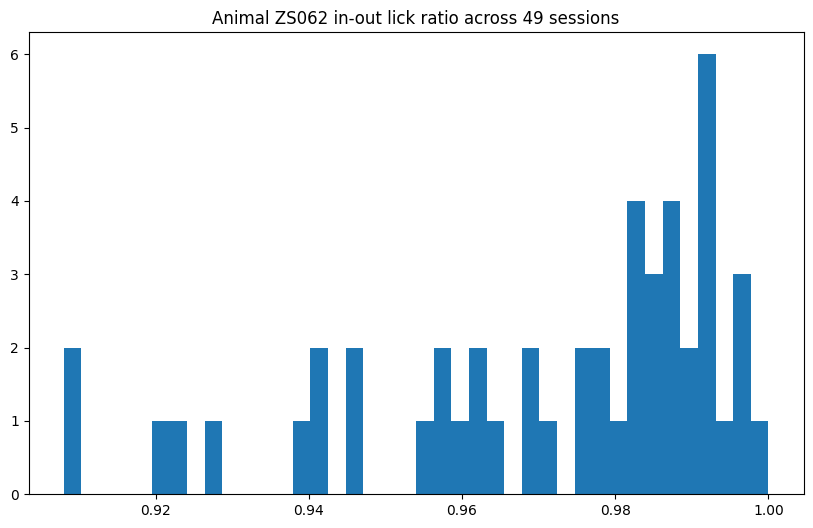

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.hist(results['in_out_ratio'], bins = 40);
plt.title(f'Animal {animal_id} in-out lick ratio across {len(sessions)} sessions')

In [ ]:
quantiles_in_nrwd_ani_combined[0]

array([0.342, 0.46 , 0.698])